## Case Study: Traffic


### Import Libraries

Chat GPT an copilot was used to make time into dummievariables and understaning xgbooster.

In [203]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn

from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')


In [204]:
!pip install xgboost


python(76542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Load Dataset

In [205]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [206]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']



In [ ]:

X['date_time'] = pd.to_datetime(X['date_time'], errors="coerce")
X['month'] = X['date_time'].dt.month_name()
X['dayofweek'] = X['date_time'].dt.day_name() 
X['hour'] = X['date_time'].dt.hour

# Drop original date_time
X = X.drop(columns=['date_time'])

X.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,month,dayofweek,hour
0,NaN,288.28,0.0,0.0,40,Clouds,October,Tuesday,9
1,NaN,289.36,0.0,0.0,75,Clouds,October,Tuesday,10
2,NaN,289.58,0.0,0.0,90,Clouds,October,Tuesday,11
3,NaN,290.13,0.0,0.0,90,Clouds,October,Tuesday,12
4,NaN,291.14,0.0,0.0,75,Clouds,October,Tuesday,13


In [224]:

X_encoded = pd.get_dummies(X, columns=['month', 'dayofweek', 'hour', 'weather_main', 'holiday'], drop_first=False)
X_encoded.head()

X_encoded.to_csv("traffic.csv", index= False)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement XGBRegressor

In [210]:

reg = XGBRegressor()


In [211]:
# Fit the model
reg.fit(train_X, train_y)  


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### Evaluate Prediction Performance on Test Set

In [212]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 444.66


#### Histogram of Residuals/Errors 

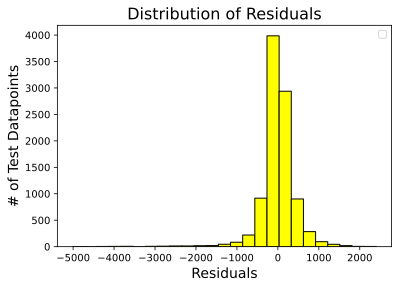

In [ ]:

all_residuals = test_y - y_pred

plt.figure(figsize=(6, 4), dpi=150)
plt.hist(all_residuals, bins=25, color='yellow', edgecolor='black')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('# of Test Datapoints', fontsize=14)
plt.title('Distribution of Residuals', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.savefig('Residuals_Histogram.png', dpi=300)
plt.show()


#### Scatter Plot of Predicted Vs. Actual Values

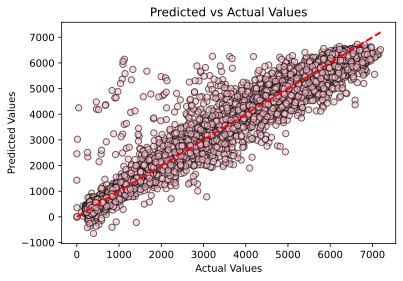

In [ ]:

plt.figure(figsize = (6, 4), dpi = 150)
plt.scatter(test_y, y_pred, color = 'pink', alpha = 0.6, edgecolor = 'black', s = 40)

plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig('Predicted_vs_Actual.png', dpi=300)
plt.show()

#### Feature Importance Plot

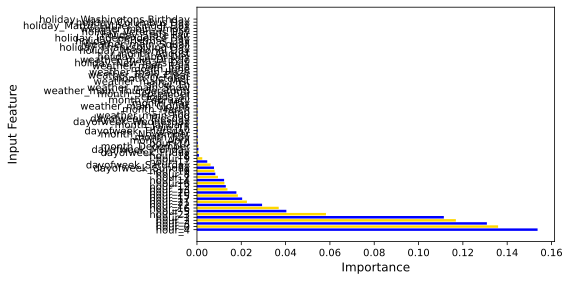

In [ ]:
importance = reg.feature_importances_
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns=['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'],color=['blue', 'gold'])

plt.xlabel("Importance", fontsize=12)
plt.ylabel("Input Feature", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.tight_layout()

plt.savefig('Feature_Importance.png', dpi=300)
plt.show()


### Prediction Intervals for Regression
<img src="Prediction_Interval.png" width="500" style="float: center"/>

#### **What is a Prediction Interval?**
- It is a **range of values** within which a new observation is expected to fall with a **certain probability**, given the existing data and model.

- **Probability**: The width of the prediction interval depends on the **desired confidence level**, (e.g., 95%), with higher confidence levels leading to wider intervals.

#### **Confidence Level of Prediction Interval**

- The confidence level of a prediction interval indicates the probability that the interval will contain the true value of the parameter being estimated.

- Mathematically, the confidence level of a prediction interval is denoted by $ (1 - \alpha) \times 100\% $, where $ \alpha $ is the significance level.

#### **Why Prediction Intervals are Useful?**

- **Uncertainty Quantification**: They provide a measure of the uncertainty in individual predictions, which is crucial for risk assessment and decision-making.

- **Communication**: They are an effective tool for communicating the uncertainty in predictions to stakeholders, making the model's predictions more interpretable.

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

In [216]:
import os

os.cpu_count()

8

In [217]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

# alpha for confidence level (e.g. 0.1 -> 90%)
alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 2.7526769638061523s


In [218]:
# Predicted values point prediction for all the students
y_test_pred

array([5815.6196 , 2315.0784 ,  734.85504, ..., 2014.8047 , 2803.4307 ,
        585.0764 ], dtype=float32)

In [219]:
# Prediction Intervals for all the students
y_test_pis

array([[[5111.10351562],
        [6395.58984375]],

       [[1660.54516602],
        [2862.16699219]],

       [[ 114.15618896],
        [1314.16021729]],

       ...,

       [[1342.63409424],
        [2570.85229492]],

       [[2196.87878418],
        [3415.25292969]],

       [[  15.91815186],
        [1215.73986816]]])

In [220]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2762.500000,2145.97,3351.10
34004,5251,5189.549805,4567.01,5768.46
46086,2224,2014.800049,1342.63,2570.85
42579,2928,2803.429932,2196.88,3415.25
23709,910,585.080017,15.92,1215.74


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [221]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.74%


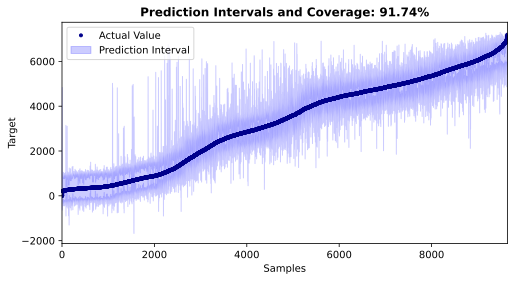

In [222]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value", color='darkblue')

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="blue", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);


plt.savefig('Prediction_Intervals.png')
plt.show()

### Save Model

In [223]:


# save the MAPIE wrapper
with open("mapie_regressor.pkl", "wb") as f:
    pickle.dump(mapie, f)


Exception ignored in: <function ResourceTracker.__del__ at 0x104ca5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107429c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102849c60>
Traceback (most recent call last